# FAQ ChatBot model prototype notebook

## 1. Project Overview

The aim of this notebook is to use asymmetric semantic search to retrieve the top 3 closest answers from the ReactJS FAQ dataset based on a user's question input. Questions and answers are mapped to the same vector space using a pre-trained SBERT model. Given a new question, the closest 3 answers are retrieved using similarity search. The dataset will be split, with 90% used as reference corpus and 10% of questions reserved to evaluate how well the system retrieves relevant answers.

https://www.sbert.net/examples/sentence_transformer/applications/semantic-search/README.html

## 2. Dataset

The ReactJS FAQ dataset will be used, which consists approximately 26,300 question-answer pairs in a JSON format.

https://www.kaggle.com/datasets/savanidhruv/reactjs-faq-dataset

In [1]:
import pandas as pd

# Import display module from IPython to render pandas DataFrames in VS Code notebooks
# from IPython.display import display # uncomment if needed to display multiple objects in one cell

In [2]:
# Load dataset from kaggle

import kagglehub
from kagglehub import KaggleDatasetAdapter

# JSON file inside the ReactJS FAQ dataset folder
file_path = "React_dataset.json"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "savanidhruv/reactjs-faq-dataset",
  file_path,
)

print("First 5 records:")
df.head()

c:\Users\wraiuu\Documents\Portfolio-Projects\ReactJS-FAQ-ChatBot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First 5 records:


,question,answer,detailedanswer,detailed_answer,argument
0,What is React?,React is an open-source JavaScript library for...,NaN,NaN,NaN
1,What is a Date Picker in React?,A Date Picker in React is a UI component that ...,NaN,NaN,NaN
2,what are feature of React?,"1) Component-Based Architecture, 2) Virtual DO...",NaN,NaN,NaN
3,Which libraries are commonly used for date pic...,"Popular libraries include react-datepicker, re...",NaN,NaN,NaN
4,How to install react-datepicker?,Run `npm install react-datepicker` and also in...,NaN,NaN,NaN


## 3. Preprocessing



In [3]:
# Remove other columns from the dataframe
df = df[["question", "answer"]]

# Drop rows where either 'question' or 'answer' is null
df = df.dropna(subset=["question", "answer"]).reset_index(drop=True)

# Display the full answers
pd.set_option("display.max_colwidth", None)

# Shuffle dataset (so that similar Q and A pairs are not grouped)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show the first 10 rows of the table
print("First 5 Q and A pairs:")
df.head()

First 5 Q and A pairs:


,question,answer
0,How do you debug “No response from server” in urql?,"""No response from server"" in urql typically means the HTTP request was sent but no response was received within a reasonable timeframe, or the connection was abruptly closed. This often points to a network issue, a server that's down, or a firewall blocking the connection. To debug:\n1. **Check network connection:** Ensure your device has internet access.\n2. **Verify server status:** Is your GraphQL server running and accessible?\n3. **Correct endpoint URL:** Double-check the `url` in your `urql` client configuration.\n4. **Firewall/Proxy:** See if a firewall or proxy is blocking the request.\n5. **Browser DevTools:** Open the Network tab in your browser's developer tools. Look for the pending request; it might eventually show a timeout or connection refused error.\n6. **Server Logs:** Check your GraphQL server logs for any incoming request attempts or errors."
1,How to enforce token usage via linting rules?,"To enforce token usage, create custom Stylelint rules or extend your ESLint config with plugins that analyze your .css.ts files. These rules should check whether hardcoded values (like colors or spacing) match predefined token values. You can use Abstract Syntax Tree (AST) parsing with ESLint or integrate with tools like `stylelint-declaration-strict-value` to disallow raw values and ensure tokens are consistently used."
2,How to integrate store with Three.js for UI sync?,"1. Three.js render loop is external, so sync Zustand state manually:\n```ts\nstore.subscribe(state => {\n mesh.position.x = state.x;\n});\n```\n2. Use `useFrame()` in `@react-three/fiber` to pull values from store:\n```ts\nuseFrame(() => {\n meshRef.current.position.x = useStore.getState().x;\n});\n```\n3. Avoid using `useStore()` inside `useFrame()` directly for performance."
3,How do you test WebSockets in Playwright?,Intercept and monitor WebSocket messages using the `page.on('websocket')` event or test the UI reflecting live updates:\n\n```ts\nawait page.goto('/chat');\nawait expect(page.locator('text=User joined')).toBeVisible();\n```
4,How to test styling logic using Jest + React Testing Library?,"You can use `@testing-library/react` along with Stitches' `toString()` method to test styling. Also, test for class names or inline styles:\n\n```tsx\nimport { render } from '@testing-library/react';\nimport { styled } from '@stitches/react';\n\nconst Button = styled('button', {\n backgroundColor: 'red',\n});\n\ntest('Button renders with correct styles', () => {\n const { getByRole } = render(<Button>Click</Button>);\n const button = getByRole('button');\n expect(button).toHaveStyle('background-color: red');\n});\n```\nStitches generates scoped class names, so testing for presence of styles via inline snapshots or `jest-styled` libraries can be useful."


Next we will separate the data into a 90/10 split: a training corpus and a testing set. Since we are using a pre-trained model, we are not training the model itself. Instead, we use the training corpus to generate embeddings, and then test accuracy by checking whether the model retrieves the correct answers for unseen questions in the test set.

In [4]:
# Calculate the size of the training corpus (90% of the dataset)
train_size = int(len(df) * 0.9)

# Separate dataset into training corpus and testing set
train_df = df.iloc[:train_size].reset_index(drop=True)
test_df  = df.iloc[train_size:].reset_index(drop=True)

# Separate questions and answers
train_questions = train_df["question"].tolist()
train_answers   = train_df["answer"].tolist()

test_questions = test_df["question"].tolist()
test_answers   = test_df["answer"].tolist()

print(f"Train size: {len(train_questions)}, Test size: {len(test_questions)}")


Train size: 23653, Test size: 2629


## 4. Embedding Generation

In [5]:
import torch

from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Training embeddings
train_question_embeddings = embedder.encode(train_questions, convert_to_tensor=True)
train_answer_embeddings   = embedder.encode(train_answers, convert_to_tensor=True)

# Test embeddings
test_question_embeddings  = embedder.encode(test_questions, convert_to_tensor=True)
test_answer_embeddings    = embedder.encode(test_answers, convert_to_tensor=True)


## 5. Similarity Check

First we will check the cosine simularity between question and answer pairs

In [6]:
import random

sample_size = 5  # number of pairs to check
sample_indices = random.sample(range(len(train_questions)), sample_size)

results = []
for i in sample_indices:
    similarity = embedder.similarity(train_question_embeddings[i], train_answer_embeddings[i])
    results.append({
        "Question": train_questions[i],
        "Answer": train_answers[i],
        "Similarity": float(similarity)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display the table
df


,Question,Answer,Similarity
0,How do you write stories for components with error handling?,"Pass error props or throw manually to test fallback UI:\n\nexport const WithError = () => <UserCard error=""not found"" />;\n\nFor componentDidCatch:\nexport const Crash = () => {\n throw new Error('Force crash');\n};",0.476587
1,"How to extract responsive styles (e.g. breakpoints, tokens)?",1. Define breakpoints and responsive tokens in your Chakra theme.\n2. Configure Extract to include responsive style rules.\n3. Use `responsive` prop in components for breakpoint-specific styles.\n4. Inspect generated CSS for media queries and tokens.,0.619018
2,How to implement pagination cursor state?,"Manage pagination with atoms for cursor and data:\n```ts\n// state.ts\nimport { atom, selector } from 'recoil';\n\nexport const cursorAtom = atom({ key: 'cursor', default: '' });\n\nexport const pageDataSelector = selector({\n key: 'pageData',\n get: async ({ get }) => {\n const cursor = get(cursorAtom);\n const response = await fetch(`/api/data?cursor=${cursor}`);\n const { items, nextCursor } = await response.json();\n return { items, nextCursor };\n },\n});\n\n// Component.tsx\nimport { useRecoilState, useRecoilValue } from 'recoil';\n\nconst Component = () => {\n const [cursor, setCursor] = useRecoilState(cursorAtom);\n const { items, nextCursor } = useRecoilValue(pageDataSelector);\n return (\n <div>\n {items.map(item => <p key={item.id}>{item.name}</p>)}\n <button onClick={() => setCursor(nextCursor)} disabled={!nextCursor}>Next</button>\n </div>\n );\n};\n```\n**Notes**:\n- Use `<Suspense>` for loading:\n ```ts\n <Suspense fallback={<p>Loading...</p>}><Component /></Suspense>\n ```\n- Persist cursor with `atomEffects`:\n ```ts\n const cursorAtom = atom({ key: 'cursor', default: '', effects: [/* localStorage logic */] });\n ```\n- Add `atomFamily` for per-page state.",0.586823
3,How do you fix “element not found” errors in Playwright?,"This usually means the selector is wrong or the element hasn't rendered yet. Solutions:\n- Use `await expect(locator).toBeVisible()` instead of `locator.click()` directly\n- Add waiting logic like `await locator.waitFor()`\n- Use more specific or stable selectors (e.g., `data-testid`)",0.323164
4,How to maintain modal open/close state in Redux?,"Create a UI slice:\n```ts\nconst uiSlice = createSlice({\n name: 'ui',\n initialState: { modals: {} },\n reducers: {\n openModal: (state, action) => { state.modals[action.payload] = true; },\n closeModal: (state, action) => { state.modals[action.payload] = false; }\n }\n});\n```",0.551774


## 6. Testing

Next we need to test how well new questions pair with existing answers in the training corpus.

https://www.sbert.net/examples/sentence_transformer/applications/semantic-search/README.html

In [7]:
from sentence_transformers import util

top_k = 3  # number of top matches to show

# Run semantic search
results = util.semantic_search(test_question_embeddings, train_answer_embeddings, top_k=top_k)

# Build a DataFrame
rows = []
for i, hits in enumerate(results):
    for rank, hit in enumerate(hits, start=1):
        rows.append({
            "Test Question": test_questions[i],
            "Rank": rank,
            "Training Answer": train_answers[hit['corpus_id']],
            "Similarity": hit['score']
        })

df = pd.DataFrame(rows)

# Display 3 questions
df.head(3 * top_k)

,Test Question,Rank,Training Answer,Similarity
0,How do you throttle form submissions in Formik?,1,Formik doesn't have rate limiting built-in. You must enforce this on the backend using IP-based or account-based throttling. On the client:\n- You can debounce or throttle API calls with libraries like `lodash.throttle`\n- Use Formik’s `isSubmitting` flag to block rapid resubmission\n- Show appropriate error messages if rate-limiting is triggered by the server,0.754446
1,How do you throttle form submissions in Formik?,2,"Use a throttling utility like lodash’s `throttle` or a custom hook to limit how often `onSubmit` can be triggered:\n\nimport { throttle } from 'lodash-es';\n\nconst onSubmitThrottled = throttle(onSubmit, 1000, { leading: true, trailing: false });\n\n<form onSubmit={handleSubmit(onSubmitThrottled)}>\n <!-- form fields -->\n</form>",0.628531
2,How do you throttle form submissions in Formik?,3,"Rate limiting can be implemented on the client by disabling rapid submissions using throttling/debouncing (e.g., Lodash). On the server, detect excessive requests from an IP/user and return a 429 response. In the form, catch this and display a cooldown message ('Please wait 30 seconds before submitting again'). Optionally show a countdown. Persist cooldown state in localStorage or context. For anonymous users, use fingerprinting or device ID to enforce limits. Always inform users when their request is blocked to improve UX.",0.626402
3,How do you use useCallback with streaming rendering?,1,"useCallback is a hook that memoizes a function so it doesn’t get recreated on every render, useful for preventing unnecessary re-renders in child components.",0.595360
4,How do you use useCallback with streaming rendering?,2,"`useCallback` returns a memoized function, which appears in DevTools as a stable function reference. To debug it, inspect whether the callback reference changes between renders (shown by a change in hook value). Unexpected changes may indicate a missing or incorrect dependency.",0.588214
5,How do you use useCallback with streaming rendering?,3,`useCallback` helps you avoid re-creating functions on every render. It's useful when passing callbacks to optimized child components that rely on reference equality to avoid re-rendering.,0.583129
6,How do you set the language attribute on the HTML tag with React Helmet?,1,"Set the `lang` attribute in `<html>` using React Helmet:\n\n```jsx\n<Helmet>\n <html lang=""en-US"" />\n</Helmet>\n```\n\nThis improves screen reader behavior by ensuring correct language pronunciation and localization settings.\n\nFor dynamic locales:\n```jsx\n<Helmet>\n <html lang={userLocale} />\n</Helmet>\n```\n\nAlways provide valid BCP 47 language codes like `'es'`, `'ar'`, or `'zh-CN'`.",0.751366
7,How do you set the language attribute on the HTML tag with React Helmet?,2,"Manage multilingual head tags by detecting locale and passing translations into Helmet:\n\n```jsx\nimport { useTranslation } from 'react-i18next';\n\nfunction LocalizedHelmet({ titleKey, descriptionKey }) {\n const { t, i18n } = useTranslation();\n return (\n <Helmet>\n <html lang={i18n.language} />\n <title>{t(titleKey)}</title>\n <meta name=""description"" content={t(descriptionKey)} />\n <link rel=""alternate"" hrefLang={i18n.language} href={window.location.href} />\n </Helmet>\n );\n}\n```\n\nAlso consider adding alternate language links and canonical URLs for full internationalization support.",0.705496
8,How do you set the language attribute on the HTML tag with React Helmet?,3,"You set the `charset` meta tag with React Helmet by including a `<meta>` tag with the `charset` attribute as a child of the `Helmet` component. It's generally recommended to set this as `utf-8` to ensure proper character encoding for most languages.\n\n```jsx\nimport React from 'react';\nimport { Helmet } from 'react-helmet';\n\nfunction MyApp() {\n return (\n <div>\n <Helmet>\n <title>My UTF-8 Encoded App</title>\n <meta charSet=""utf-8"" />\n <meta n

Now we can check how well these align with their actual answers and compare the simularity between the top answer and the real answer.

In [8]:
rows = []
for i, retrieved_results in enumerate(results):  # results from semantic_search
    correct_sim = util.cos_sim(test_question_embeddings[i], test_answer_embeddings[i]).item()
    top_result = retrieved_results[0]  # best training answer
    rows.append({
        "Test Question": test_questions[i],
        "Correct Test Answer": test_answers[i],
        "Correct Similarity": correct_sim,
        "Top Retrieved Answer": train_answers[top_result['corpus_id']],
        "Top Retrieved Similarity": top_result['score']
    })

df = pd.DataFrame(rows)
df.head()

,Test Question,Correct Test Answer,Correct Similarity,Top Retrieved Answer,Top Retrieved Similarity
0,How do you throttle form submissions in Formik?,"Throttle form submissions by wrapping `onSubmit` logic with `lodash.throttle()` or tracking the last submit time:\n```jsx\nconst throttledSubmit = useCallback(throttle(values => submitToApi(values), 5000), []);\n<Formik onSubmit={throttledSubmit} />\n```",0.670487,Formik doesn't have rate limiting built-in. You must enforce this on the backend using IP-based or account-based throttling. On the client:\n- You can debounce or throttle API calls with libraries like `lodash.throttle`\n- Use Formik’s `isSubmitting` flag to block rapid resubmission\n- Show appropriate error messages if rate-limiting is triggered by the server,0.754446
1,How do you use useCallback with streaming rendering?,"When using `useCallback` in streaming environments, ensure that the memoized function doesn’t rely on partially loaded or unresolved data. Functions should either be deferred until all dependencies are ready or guarded with null-checks and fallbacks to prevent runtime errors.",0.666540,"useCallback is a hook that memoizes a function so it doesn’t get recreated on every render, useful for preventing unnecessary re-renders in child components.",0.595360
2,How do you set the language attribute on the HTML tag with React Helmet?,"You can set the `lang` attribute on the `<html>` tag using Helmet like this:\n```jsx\n<Helmet htmlAttributes={{ lang: 'en' }} />\n```\nThis is particularly important for accessibility, SEO, and internationalization. You can dynamically switch this based on app locale settings or i18n state. React Helmet ensures this attribute is injected directly into the DOM on load or update.",0.842265,"Set the `lang` attribute in `<html>` using React Helmet:\n\n```jsx\n<Helmet>\n <html lang=""en-US"" />\n</Helmet>\n```\n\nThis improves screen reader behavior by ensuring correct language pronunciation and localization settings.\n\nFor dynamic locales:\n```jsx\n<Helmet>\n <html lang={userLocale} />\n</Helmet>\n```\n\nAlways provide valid BCP 47 language codes like `'es'`, `'ar'`, or `'zh-CN'`.",0.751366
3,How to create reusable layout components with Tailwind?,"Reusable layout components in React with Tailwind can be created by combining flexbox/grid utilities and defining consistent padding, margins, and max widths.\n\nExample: Container component to center and constrain content width:\n\n```jsx\nfunction Container({ children }) {\n return <div className=""max-w-7xl mx-auto px-4 sm:px-6 lg:px-8"">{children}</div>;\n}\n```\n\nExample: Flex Row component with spacing:\n\n```jsx\nfunction FlexRow({ children, gap = '4' }) {\n return <div className={`flex space-x-${gap}`}>{children}</div>;\n}\n```\n\nExample: Responsive grid layout:\n\n```jsx\nfunction GridLayout({ children }) {\n return <div className=""grid grid-cols-1 md:grid-cols-3 gap-6"">{children}</div>;\n}\n```\n\nUsing these components across your app ensures consistent layout and spacing. You can also extend these to accept props for custom behavior or styles.",0.579723,"Use Tailwind for layout and utility styling, and antd for interactive components. Combine them by wrapping antd components in Tailwind utility classes via `className`. Avoid class name conflicts and ensure consistent theming.",0.712194
4,How do you use SWR in a CMS application?,Load pages and content blocks:\n```tsx\nfunction usePageContent(slug) {\n const { data } = useSWR(`/api/pages/${slug}`);\n return data;\n}\n\nfunction useBlocks(pageId) {\n const { data } = useSWR(`/api/blocks?page=${pageId}`);\n return data;\n}\n```\n**Notes**:\n- Versioned content can be fetched via query params.\n- Allow preview/edit modes.,0.128066,"SWR is a React Hooks library for data fetching, developed by Vercel. It simplifies and optimizes the process of fetching, caching, and updating data in React applications.",0.562980


## 7. Evaluation

https://pretrained.dev/article/How_to_evaluate_the_performance_of_pretrained_models.html

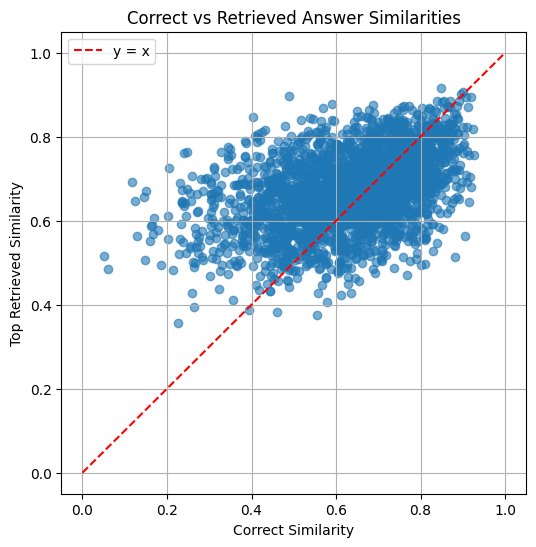

Above diagonal (retrieved > correct): 59.91% (1575/2629)
Below diagonal (retrieved < correct): 39.75% (1045/2629)
Equal (retrieved == correct): 0.34% (9/2629)


In [22]:
# Check how often the top answer is the correct answer and plot the cluster

import numpy as np
import matplotlib.pyplot as plt

correct = df["Correct Similarity"].to_numpy()
retrieved = df["Top Retrieved Similarity"].to_numpy()

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(correct, retrieved, alpha=0.6)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="y = x")
plt.xlabel("Correct Similarity")
plt.ylabel("Top Retrieved Similarity")
plt.title("Correct vs Retrieved Answer Similarities")
plt.legend()
plt.grid(True)
plt.show()

# Numeric summary
above = np.sum(retrieved > correct)
below = np.sum(retrieved < correct)
equal = np.sum(retrieved == correct)
total = len(correct)

print(f"Above diagonal (retrieved > correct): {above/total:.2%} ({above}/{total})")
print(f"Below diagonal (retrieved < correct): {below/total:.2%} ({below}/{total})")
print(f"Equal (retrieved == correct): {equal/total:.2%} ({equal}/{total})")

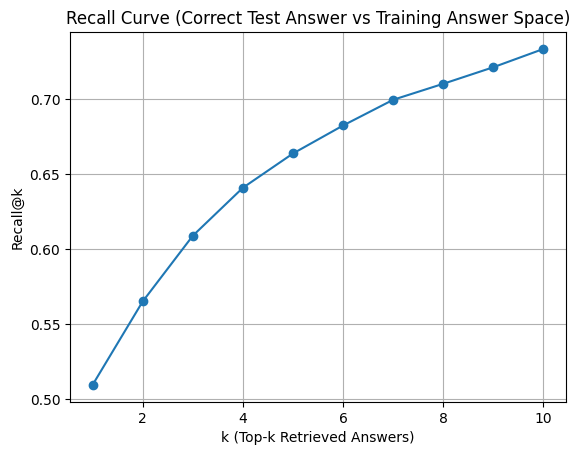

In [24]:
# Check the recall for the correct answer being in the top k results.

max_k = 10
recall_at_k = []

for k in range(1, max_k+1):
    hits_in_topk = 0
    
    for i, q_emb in enumerate(test_question_embeddings):
        # Similarities with *all* training answers
        sims = util.cos_sim(q_emb, train_answer_embeddings)[0].cpu().numpy()
        
        # Sort indices by similarity (descending)
        ranked_indices = np.argsort(-sims)
        
        # Also compute similarity with the correct test answer
        correct_sim = util.cos_sim(q_emb, test_answer_embeddings[i]).item()
        
        # Find rank of correct answer among training set
        # (by comparing its similarity to the distribution of training sims)
        rank = np.sum(sims >= correct_sim)  # number of train answers >= correct one
        
        if rank <= k:   # correct answer is within top-k
            hits_in_topk += 1
    
    recall = hits_in_topk / len(test_questions)
    recall_at_k.append(recall)

plt.plot(range(1, max_k+1), recall_at_k, marker="o")
plt.xlabel("k (Top-k Retrieved Answers)")
plt.ylabel("Recall@k")
plt.title("Recall Curve (Correct Test Answer vs Training Answer Space)")
plt.grid(True)
plt.show()

The Recall only reaches 0.7 when k=7 so only retrieving 3 answers may not be accurate enough. However there many be multiple correct answers for each question in the dataset that don't exactly match the pairs.